In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [2]:
# root mean squared error
def RMSE(y, y_predict):
    return math.sqrt(np.sum((y - y_predict)**2)/len(y))  


# load training and test data
train_data = np.loadtxt('train/train_data.dat')
test_data  = np.loadtxt('test/test_data.dat')

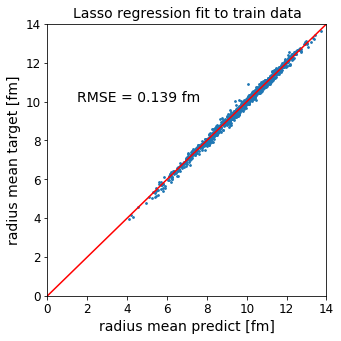

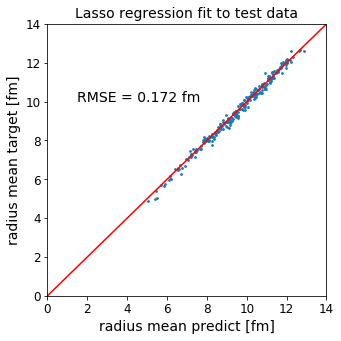

mean radius RMSE = 0.172


In [3]:
# Train regression model for mean fireball radius
#
# multipolynomial Lasso regression with feature scaling
#
# hyperparameters
order    = 3   
alpha    = 0.0053

# prepare train / test data
features = 15
X_train = train_data[:,0:15].reshape(-1, features)
y_train = train_data[:,-2].reshape(-1,1)

X_test  = test_data[:,0:15].reshape(-1, features)
y_test  = test_data[:,-2].reshape(-1,1)

# train regression model
regression_mean = Pipeline([('scale', StandardScaler()), 
                            ('poly', PolynomialFeatures(order)),
                            ('reg', Lasso(alpha=alpha))])

regression_mean.fit(X_train, y_train)


# predictions and RMSE
y_train_predict = regression_mean.predict(X_train).reshape(-1,1)
y_test_predict  = regression_mean.predict(X_test).reshape(-1,1)

RMSE_train = RMSE(y_train, y_train_predict)
RMSE_test  = RMSE(y_test, y_test_predict)  

x = np.linspace(0, 15, 10)

# plot fit
plt.figure(figsize = (5,5))
plt.plot(x, x, color = 'red')
plt.scatter(y_train_predict, y_train, s = 3)
plt.xlim(0,14)
plt.ylim(0,14)
plt.title('Lasso regression fit to train data', fontsize=14)
plt.xlabel('radius mean predict [fm]', fontsize=14)
plt.ylabel('radius mean target [fm]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(1.5, 10, 'RMSE = %.3f fm' % RMSE_train, fontsize=14)
plt.show()

plt.figure(figsize = (5,5))
plt.plot(x, x, color = 'red')
plt.scatter(y_test_predict, y_test, s = 3)
plt.xlim(0,14)
plt.ylim(0,14)
plt.title('Lasso regression fit to test data', fontsize=14)
plt.xlabel('radius mean predict [fm]', fontsize=14)
plt.ylabel('radius mean target [fm]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(1.5, 10, 'RMSE = %.3f fm' % RMSE_test, fontsize=14)
plt.show()

mean_radius_RMSE_test = RMSE_test
print('mean radius RMSE = %.3f' % mean_radius_RMSE_test)

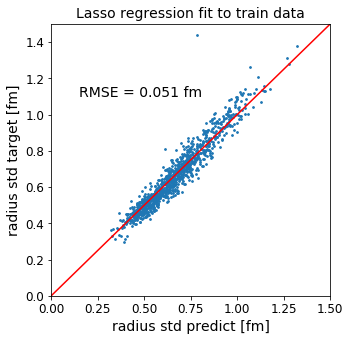

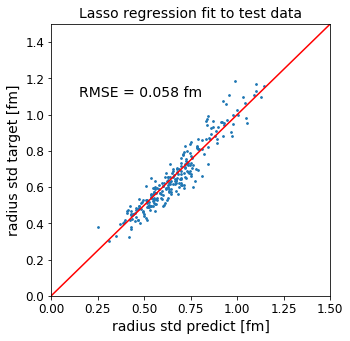

std radius RMSE = 0.058


In [4]:
# Train regression model for std fireball radius
#
# cubic polynomial Lasso regression with feature scaling
#
# hyperparameters
order = 3   
alpha = 0.0023

# prepare data
X_train = train_data[:,0:15].reshape(-1, 15)
X_test  = test_data[:,0:15].reshape(-1, 15)
y_train = train_data[:,-1].reshape(-1,1)
y_test  = test_data[:,-1].reshape(-1,1)

# train regression model
regression_std = Pipeline([('scale', StandardScaler()), 
                           ('poly', PolynomialFeatures(order)),
                           ('reg', Lasso(alpha=alpha))])

regression_std.fit(X_train, y_train)

# predictions and RMSE
y_train_predict = regression_std.predict(X_train).reshape(-1,1)
y_test_predict  = regression_std.predict(X_test).reshape(-1,1)

RMSE_train = RMSE(y_train, y_train_predict)
RMSE_test  = RMSE(y_test, y_test_predict)  

x = np.linspace(0, 15, 10)

# plot fit
plt.figure(figsize = (5,5))
plt.plot(x, x, color = 'red')
plt.scatter(y_train_predict, y_train, s = 3)
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.title('Lasso regression fit to train data', fontsize=14)
plt.xlabel('radius std predict [fm]', fontsize=14)
plt.ylabel('radius std target [fm]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.15,1.1, 'RMSE = %.3f fm' % RMSE_train, fontsize=14)
plt.show()
# 
plt.figure(figsize = (5,5))
plt.plot(x, x, color = 'red')
plt.scatter(y_test_predict, y_test, s = 3)
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.title('Lasso regression fit to test data', fontsize=14)
plt.xlabel('radius std predict [fm]', fontsize=14)
plt.ylabel('radius std target [fm]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.15,1.1, 'RMSE = %.3f fm' % RMSE_test, fontsize=14)
plt.show()

std_radius_RMSE_test = RMSE_test
print('std radius RMSE = %.3f' % std_radius_RMSE_test)

In [13]:
# test if auto grid size is large enough to fit all fireball radius in launch samples
#
#
# auto grid size without buffer (RMSE already included in mean, std)
#
def auto_grid_size(mean, std, number_sigmas, margin):
    return 2 * (mean  +  number_sigmas * std  + margin)


number_files = len(os.listdir('launch_model_parameters'))

number_sigmas = 2    # number of sigmas
margin        = 1    # additional margin [fm] on each side of fireball

total   = 0
success = 0
average_area = 0
average_margin = 0

for n in range (0, number_files):
    parameters = np.loadtxt('launch_model_parameters/model_parameters_' + str(n + 1) + '.dat').reshape(1,-1)
    
    mean = regression_mean.predict(parameters)[0] + mean_radius_RMSE_test
    std  = regression_std.predict(parameters)[0]  + std_radius_RMSE_test
        
    L = auto_grid_size(mean, std, number_sigmas, margin)
    average_area += L * L
    
    fireball_radius = np.loadtxt('launch_fireball_radius/fireball_radius_' + str(n + 1) + '.dat')[:,-1]
    
    for radius in fireball_radius:
        total += 1

        if L > 2*radius:
            success += 1
            average_margin += (L - 2*radius) / 2


average_area /= number_files
average_margin /= success
success_rate = 100. * success / total

print("Auto grid with %.1f sigmas and %.1f fm extra margin was able to fit %ld / %ld fireball samples" 
      % (number_sigmas, margin, success, total))
print()
print("Success rate   = %.2f" % success_rate, "%")
print("Average margin = %.2f fm" % average_margin)
print()
print("Average auto grid area = %.0f fm^2" % average_area)
print("Large fixed grid area  = 900 fm^2")


11.028542707036985 	 0.5559589216852823
Auto grid with 2.0 sigmas and 1.0 fm extra margin was able to fit 19943 / 19994 fireball samples

Success rate   = 99.74 %
Average margin = 2.64 fm

Average auto grid area = 594 fm^2
Large fixed grid area  = 900 fm^2


In [6]:
# save predictions for radius mean, std + RMSE of random model parameters to file

for n in range (0,len(os.listdir('random_model_parameters'))):
    parameters = np.loadtxt('random_model_parameters/model_parameters_' + str(n + 1) + '.dat').reshape(1,-1)
    
    # model predictions 
    mean = regression_mean.predict(parameters)[0] + mean_radius_RMSE_test
    std  = regression_std.predict(parameters)[0]  + std_radius_RMSE_test
    np.savetxt('fireball_size_predictions/fireball_size_' + str(n + 1) + '.dat', np.array([[mean, std]]))  
    break;
